# Watershed Segmentation
This notebook demonstrates the Kmeans + Watershed Segmentation technique discussed in the art style classification paper.

In [2]:
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import torch
import numpy as np
from sklearn.cluster import KMeans

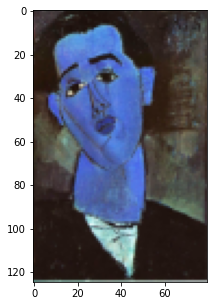

In [7]:
img = cv2.imread("./data/images/Andy_Warhol/" + "Andy_Warhol_66.jpg", cv2.COLOR_RGB2HSV)

IMG_X, IMG_Y, DIM = img.shape
imgf = torch.tensor( img.reshape(IMG_X * IMG_Y, DIM) )

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='hsv')

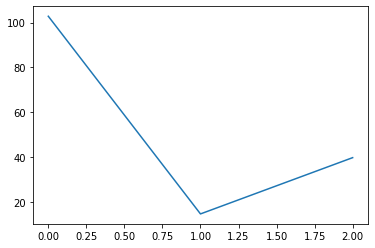

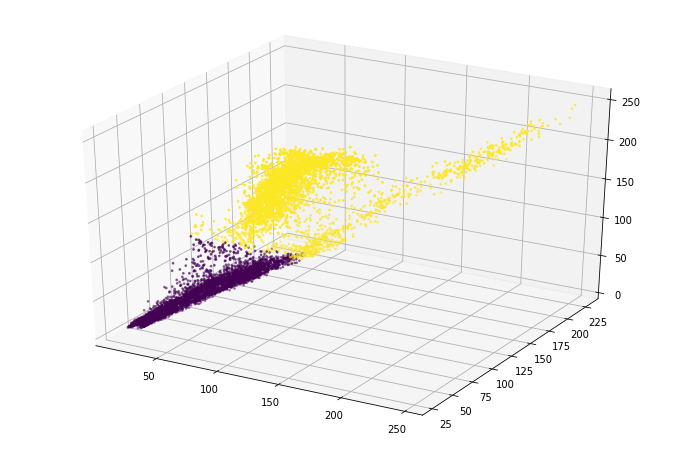

In [10]:
# K Means Clustering with 5 colors
d = []

prev_inertia = KMeans(n_clusters=1, random_state=0).fit(imgf).inertia_
prev_diff = 6e7 
prev_pct = 0

for K in range(2, 10):
    clustering_result = KMeans(n_clusters=K, random_state=0).fit(imgf)
    diff = prev_inertia - clustering_result.inertia_
    pct = diff * 100 / prev_diff
    d.append(pct)
    
    if(pct > prev_pct and K!=2):
        K -= 2
        clustering_result = KMeans(n_clusters=K, random_state=0).fit(imgf)
        break
        
    prev_pct = pct
    prev_diff = diff
    prev_inertia = clustering_result.inertia_

plt.plot(d)
# Scatter plot of the colors with the 
# colors representing segments

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# # plot
ax.scatter(imgf[:, 1], imgf[:, 0], zs=imgf[:, 2], zdir='z', c=clustering_result.labels_, s=3)

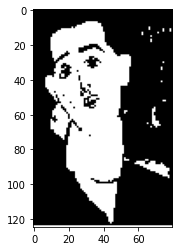

In [11]:
import skimage
from skimage import measure, color, filters
from skimage import feature, morphology, segmentation

cluster_map = np.zeros((IMG_X, IMG_Y))
for x in range(IMG_X):
    for y in range(IMG_Y):
        cluster_map[x, y] = int((clustering_result.labels_.reshape(IMG_X, IMG_Y)[x, y]*256)/K)

edges = segmentation.find_boundaries(cluster_map)
plt.imshow(cluster_map, cmap='gray')

In [12]:
from skimage import filters
from scipy.ndimage import distance_transform_edt

# Use the edges data to form a distance transform map
# which is then used to locate the local maximas

dt = distance_transform_edt(~edges)

local_max = feature.peak_local_max(dt, indices=False, min_distance=0)
peaks = feature.peak_local_max(dt, indices=True, min_distance=0)

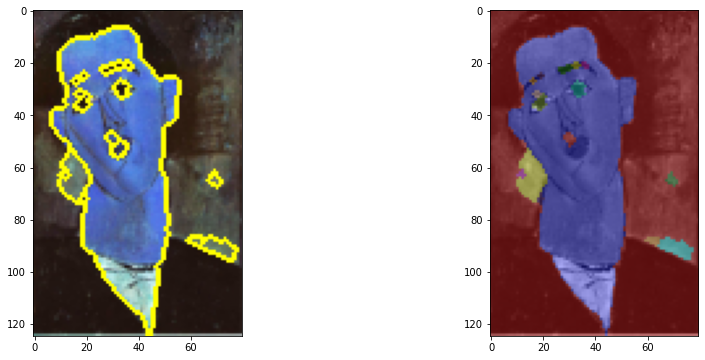

In [8]:
# Generate separating boundaries based on the 
# local maximas and perform watershed segmentation
# with the markers as the "fountains"

markers = measure.label(local_max)
labels = segmentation.watershed(-dt, markers)

f, [ pl1, pl2 ] = plt.subplots(1, 2, figsize=(15,6))
pl1.imshow(segmentation.mark_boundaries(img, labels))
pl2.imshow(color.label2rgb(labels, image=img))